In [595]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import sys
import scorecardpy as sc
import warnings
warnings.simplefilter(action = 'ignore')
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import uniform

# 原始数据获取

In [596]:
df_num = pd.read_csv(r"D:\score_card\data\cs-training.csv")

In [597]:
df_num[df_num['MonthlyIncome'].isna()==True].MonthlyIncome

6        NaN
8        NaN
16       NaN
32       NaN
41       NaN
          ..
149976   NaN
149977   NaN
149984   NaN
149992   NaN
149997   NaN
Name: MonthlyIncome, Length: 29731, dtype: float64

In [598]:
df_num.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [599]:
df_num.drop(df_num[['Unnamed: 0']],axis=1,inplace=True)

In [600]:
target = df_num['SeriousDlqin2yrs']
df_num =df_num.rename(columns = {'SeriousDlqin2yrs':'label'})

In [601]:
#处理变量名对英文名对照字
f = open("var2list.txt","r",encoding = "utf8")

r = f.readlines()
dt = {}
for info in r:
    info = info.replace("\n","").split("\t")
    dt[info[1].strip()] = info[0].strip()


In [602]:
[x for x in df_num.columns if x not in dt.keys()] #检查中英文映射是否有遗漏的

['label']

In [603]:
df_num = df_num[[x for x in df_num.columns if x in dt.keys()]+['label']]
df_num.columns = [dt[x] for x in df_num.columns if x in dt.keys()]+['label']

In [604]:
# 观察好坏标签的分布律：14：1
target.value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

# 特征筛选

## 特征质量筛选--缺失率，方差，众数比例

In [605]:
var_num = [x for x in df_num.columns if x != 'label']

In [606]:
#数值特征：缺失率和方差
df_num_describe= df_num[var_num].describe().T

In [607]:
df_num_describe['缺失率'] = round((len(df_num)-df_num_describe['count'])/len(df_num),4)
df_num_describe

,count,mean,std,min,25%,50%,75%,max,缺失率
不安全线路的轮换,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0,0.0000
年龄,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0,0.0000
逾期30-59天,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0,0.0000
利率,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0,0.0000
月收入,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0,0.1982
未结信贷额度和贷款数量,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0,0.0000
逾期90天次数,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0,0.0000
房地产贷款或贷款行数,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0,0.0000
逾期60-89天,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0,0.0000
受抚养人数量,146076.0,0.757222,1.115086,0.0,0.000000,0.000000,1.000000,20.0,0.0262


### 缺失字段处理

In [608]:
# 缺失值处理
#确认缺失字段
df_num.isna().sum()

不安全线路的轮换           0
年龄                 0
逾期30-59天           0
利率                 0
月收入            29731
未结信贷额度和贷款数量        0
逾期90天次数            0
房地产贷款或贷款行数         0
逾期60-89天           0
受抚养人数量          3924
label              0
dtype: int64

<AxesSubplot:>

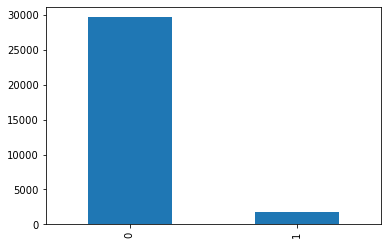

In [609]:
#缺失字段对应的标签分布
df_num[(df_num["月收入"] == 0)| (df_num["月收入"].isna())]['label'].value_counts().plot.bar()

(array([2.251e+03, 4.000e+00, 4.000e+00, 1.000e+00, 4.000e+00, 6.000e+00,
        1.000e+00, 4.000e+00, 2.000e+00, 0.000e+00, 2.700e+01, 1.000e+00,
        5.000e+00, 2.000e+00, 3.000e+00, 9.000e+00, 3.000e+00, 4.000e+00,
        5.000e+00, 2.000e+00, 4.800e+01, 0.000e+00, 4.000e+00, 3.000e+00,
        7.000e+00, 2.100e+01, 3.000e+00, 0.000e+00, 5.000e+00, 3.000e+00,
        5.500e+01, 4.000e+00, 3.000e+00, 1.200e+01, 2.000e+00, 1.100e+01,
        5.000e+00, 7.000e+00, 3.000e+00, 4.000e+00, 7.700e+01, 1.200e+01,
        8.000e+00, 1.400e+01, 8.000e+00, 2.300e+01, 3.000e+00, 3.000e+00,
        5.000e+00, 1.370e+02]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
        110., 120., 130., 140., 150., 160., 170., 180., 190., 200., 210.,
        220., 230., 240., 250., 260., 270., 280., 290., 300., 310., 320.,
        330., 340., 350., 360., 370., 380., 390., 400., 410., 420., 430.,
        440., 450., 460., 470., 480., 490., 500.]),
 <BarContainer object of 50 

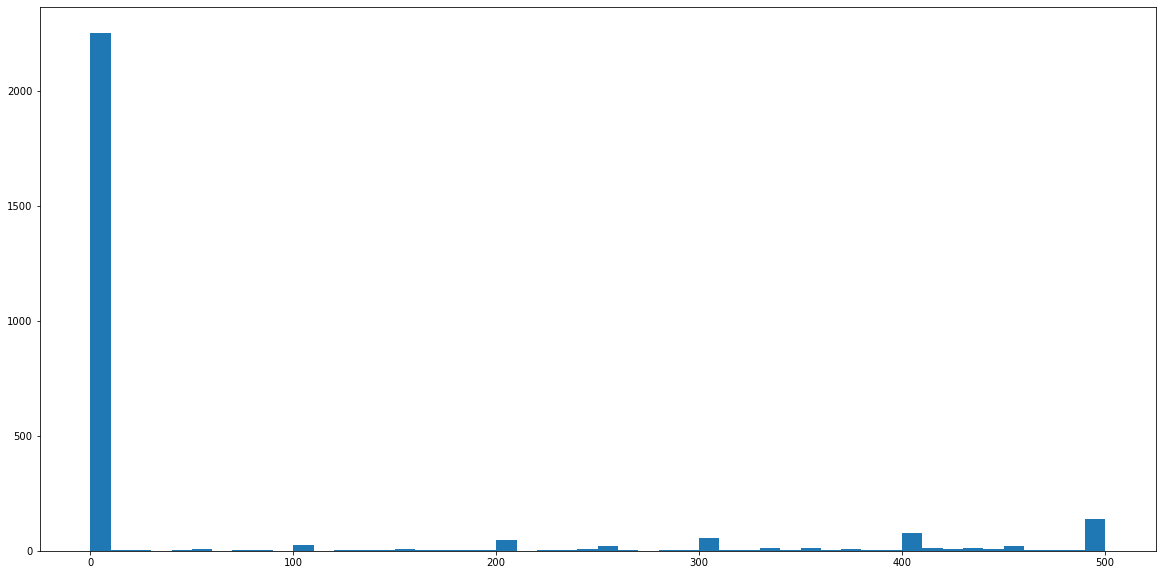

In [610]:
#缺失字段的数据分布
plt.figure(figsize=(20,10))
plt.hist(x= df_num.月收入,range=(0,500),bins = 50)


In [611]:
#核密度估计图 --样本本身的分布特征
plt.figure(figsize=(20,10))
df_num.MonthlyIncome.plot.kde()

AttributeError: 'DataFrame' object has no attribute 'MonthlyIncome'

<Figure size 1440x720 with 0 Axes>

In [613]:
#删除缺失字段行数据
df_num.drop(df_num[df_num['月收入'].isna()==True].index,inplace=True)
df_num.drop(df_num[df_num['月收入']==0].index,inplace=True)

In [614]:
df_num.isna().sum()

不安全线路的轮换       0
年龄             0
逾期30-59天       0
利率             0
月收入            0
未结信贷额度和贷款数量    0
逾期90天次数        0
房地产贷款或贷款行数     0
逾期60-89天       0
受抚养人数量         0
label          0
dtype: int64

In [615]:
df_num.dtypes

不安全线路的轮换       float64
年龄               int64
逾期30-59天         int64
利率             float64
月收入            float64
未结信贷额度和贷款数量      int64
逾期90天次数          int64
房地产贷款或贷款行数       int64
逾期60-89天         int64
受抚养人数量         float64
label            int64
dtype: object

In [616]:
df_num['受抚养人数量'] = df_num.受抚养人数量.astype('int64')

In [617]:
#方差为0的特征删除
print(df_num_describe.loc[df_num_describe['std'] == 0].index)

Index([], dtype='object')


In [618]:
#空值率大于0.9的特征删除
print(df_num_describe.loc[df_num_describe['缺失率'] > 0.9].index)

Index([], dtype='object')


In [619]:
#更新数值型变量列表
var_num = [x for x in var_num if x not in df_num_describe.loc[df_num_describe['std'] == 0].index and x not in df_num_describe.loc[df_num_describe['缺失率'] > 0.9].index]

In [620]:
# 类别特征要考虑众数比例和缺失率

In [621]:
'''
eda_tmp 用来保存所有变量的数据分析结果，根据筛选的流程，会在最后的字段标注是否删除和删除原因
'''
eda_tmp = df_num_describe
eda_tmp['是否删除'] = np.where(eda_tmp['std'] == 0,1,0)
eda_tmp['删除原因'] = np.where(eda_tmp['是否删除'] == 1,"数据质量","")

In [622]:
eda_tmp

,count,mean,std,min,25%,50%,75%,max,缺失率,是否删除,删除原因
不安全线路的轮换,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0,0.0000,0,
年龄,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0,0.0000,0,
逾期30-59天,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0,0.0000,0,
利率,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0,0.0000,0,
月收入,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0,0.1982,0,
未结信贷额度和贷款数量,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0,0.0000,0,
逾期90天次数,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0,0.0000,0,
房地产贷款或贷款行数,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0,0.0000,0,
逾期60-89天,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0,0.0000,0,
受抚养人数量,146076.0,0.757222,1.115086,0.0,0.000000,0.000000,1.000000,20.0,0.0262,0,


## 特征筛选：相关性

<AxesSubplot:>

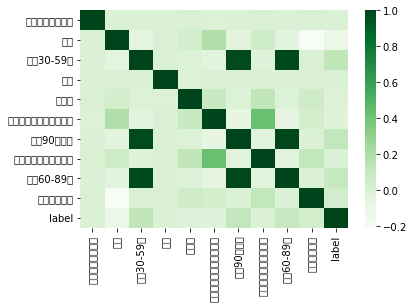

In [623]:
sns.heatmap(df_num.corr(),cmap="Greens")

In [627]:
##删除两两相关变量中iv较低者
def get_sc_iv(df_num,features,label = 'label',bin_num_limit = 10,method = 'chimerge'):
    exclude_cols = ['label']
    iv_dict = {}
    i = 0
    for col in features:
        try:
            i += 1
            print(i,col)
            bins = sc.woebin(df_num[[col,label]],y = label,bin_num_limit = bin_num_limit,method = method)
            iv_dict[col] = bins[col]
        except:
            print(col)
    woe_bins = pd.DataFrame()
    for key in iv_dict:
        woe_bins = woe_bins.append(iv_dict[key])
    woe_bins = woe_bins[~woe_bins['variable'].isin(exclude_cols)].rename(columns = {'variable':'cols'})
    return woe_bins


In [630]:
sc_iv = get_sc_iv(tmp_iv,var_num,label = 'label')

1 不安全线路的轮换
[INFO] creating woe binning ...
2 年龄
[INFO] creating woe binning ...
3 逾期30-59天
[INFO] creating woe binning ...
4 利率
[INFO] creating woe binning ...
5 月收入
[INFO] creating woe binning ...
6 未结信贷额度和贷款数量
[INFO] creating woe binning ...
7 逾期90天次数
[INFO] creating woe binning ...
8 房地产贷款或贷款行数
[INFO] creating woe binning ...
9 逾期60-89天
[INFO] creating woe binning ...
10 受抚养人数量
[INFO] creating woe binning ...


In [631]:
sc_iv = pd.DataFrame(sc_iv.groupby("cols")['total_iv'].mean())

In [632]:
# 相关性剔除
def forward_delete_corr(df,sc_iv,col_list,threshold = None):
    """
    df:训练数据集
    col_list:变量list集合
    threshold:相关性设定的阈值
    return：相关性剔除后的变量
    
    """
    list_corr = col_list[:]
    for col in list_corr:
        corr = df.loc[:,list_corr].corr()[col]
        corr_index = [x for x in corr.index if x!=col] #去掉自身
        corr_values = [x for x in corr.values if x!=1]
        for i,j in zip(corr_index,corr_values):
            if abs(j)>=threshold:
                if sc_iv.loc[col][0] < sc_iv.loc[i][0]:
                    list_corr.remove(col)
                    break
                else:
                    list_corr.remove(i)
    return list_corr

In [633]:
#相关性变量映射关系
def corr_mapping(df,col_list,threshold=None):
    """
    df:数据集
    col_list:变量list集合
    threshold:相关性设定的阈值
    return:强相关性变量之间的映射关系表
    """
    corr_df = df.loc[:,col_list].corr()
    col_a = []
    col_b = []
    corr_value = []
    for col,i in zip(col_list[:-1],range(1,len(col_list),1)):
        high_corr_col = []
        high_corr_vale = []
        corr_series = corr_df[col][i:]
        for i,j in zip(corr_series.index,corr_series.values):
            if abs(j) >=threshold:
                high_corr_col.append(i)
                high_corr_vale.append(j)
        col_a.extend([col]*len(high_corr_col))
        col_b.extend(high_corr_col)
        corr_value.extend(high_corr_value)
    corr_map_df = pd.DataFrame({'col_A':col_a,
                                'col_B':col_b,
                                'corr':corr_value,
                               })
    return corr_map_df


In [634]:
var_num = forward_delete_corr(df_num,sc_iv,df_num.columns.tolist(),threshold=0.6)

In [635]:
eda_tmp['是否删除'] = eda_tmp.apply(lambda x : 0 if x.name in var_num and x['是否删除'] !=1 else 1,axis = 1)
eda_tmp['删除原因'] = eda_tmp.apply(lambda x :"相关性删除" if x ['是否删除'] ==1 and  x ['删除原因'] =="" else x ['删除原因'],axis = 1) 

In [636]:
eda_tmp['删除原因'].value_counts()
eda_tmp

,count,mean,std,min,25%,50%,75%,max,缺失率,是否删除,删除原因
不安全线路的轮换,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0,0.0000,0,
年龄,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0,0.0000,0,
逾期30-59天,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0,0.0000,1,相关性删除
利率,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0,0.0000,0,
月收入,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0,0.1982,0,
未结信贷额度和贷款数量,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0,0.0000,0,
逾期90天次数,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0,0.0000,0,
房地产贷款或贷款行数,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0,0.0000,0,
逾期60-89天,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0,0.0000,1,相关性删除
受抚养人数量,146076.0,0.757222,1.115086,0.0,0.000000,0.000000,1.000000,20.0,0.0262,0,


# 特征iv筛选

## 若变量有类别型变量

In [581]:
#类别性变量的分箱
def binning_cate(df,col_list,target):
    """
    df:数据集
    col_list:变量list集合
    target:目标变量的字段名
    
    return:
    bin_df:list形式，里面存储每个变量的分享结果
    iv_value:list形式，里面存储每个变量的iv值
    
    """
    total = df[target].count()
    bad = df[target].sum()
    good = total-bad
    all_odds = good*1.0/bad
    bin_df = []
    iv_value = []
    for col in col_list:
        d1 = df.groupby([col],as_index=True)
        d2 = pd.DataFrame()
        d2['min_bin'] = d1[col].min()
        d2['max_bin'] = d1[col].max()
        d2['total'] = d1[target].count()
        d2['totalrate'] = d2['total']/total
        d2['bad'] = d1[target].sum()
        d2['badrate'] = d2['bad']/d2['total']
        d2['good'] = d2['total'] - d2['bad']
        d2['goodrate'] = d2['good']/d2['total']
        d2['badattr'] = d2['bad']/bad
        d2['goodattr'] = d2['good']/good
        d2['odds'] = d2['good']/d2['bad']    
        GB_list = []
        for i in d2.odds:
            if i >=all_odds:
                GB_index = str(round((i/all_odds)*100,0)+str('G'))
            else:
                GB_index = str(round((i/all_odds)*100,0)+str('B'))
            GB_list.append(GB_index)
        d2['GB_index'] = GB_list
        d2['woe'] = np.log(d2['badattr'] / d2['goodattr'])
        d2['bin_iv'] = (d2['badattr'] - d2['goodattr'] )*d2['woe']
        d2['IV'] = d2['bin_iv'].replace(np.inf,0).sum()
        iv = d2['bin_iv'].sum().round(3)
        bin_df.append(d2)
        iv_value.append(iv)
    return bin_df,iv_values

In [582]:
#类别型变量iv的明细表
def iv_cate(df,col_list,target):
    """
    df:数据集
    col_list:变量list集合
    target:目标变量的字段名
    return；变量iv明细表
    """
    bin_df,iv_value = binning_cate(df,col_list,target)
    iv_df = pd.DataFrame({'col':col_list,
                          'iv':iv_value})
    iv_df = iv_df.sort_values('iv',ascending=False)
    return iv_df

In [583]:
df_cate['label'] = df_cor['label']

NameError: name 'df_cate' is not defined

In [584]:
data_cate_iv = pd.DataFrame(columns=['cols','bin','count','count_distr','good','bad','badprob','woe','bin_iv','total_iv','breaks'
                                    ,'is_special_values'])
for i in var_cate:
    bin_df,iv_cate = binning_cate(df_cate.fillna("Null"),[i],"label")
    for k in bin_df:
        col_name = k.index.name
        info = k.reset_index().iloc[;,[0,1,3,4,7,5,6,-3,-2,-1,2]]
        info['is_special_values'] = 'False'
        info.columns = ['cols','bin','count','count_distr','good','bad','badprob','woe','bin_iv','total_iv','breaks'
                                    ,'is_special_values']
        info['cols'] = col_name
        data_cate_iv = pd.concat((data_cate_iv,info),axis = 0)

SyntaxError: invalid syntax (Temp/ipykernel_14468/4268096270.py, line 7)

In [585]:
data_iv = pd.concat((data_cate_iv.groupby("cols").mean()[['total_iv']],sc_iv),axis = 0)

NameError: name 'data_cate_iv' is not defined

In [586]:
eda_tmp = eda_tmp.join(data_iv,how = "left")

NameError: name 'data_iv' is not defined

In [587]:
eda_tmp['删除原因'] = eda_tmp.apply(lambda x :'IV筛选' if x['删除原因'] == "" and x['total_iv'] <0.02 or x['total_iv']>1.2 else x['删除原因'])

KeyError: '删除原因'

In [588]:
eda_tmp['是否删除'] = np.where(eda_tmp['删除原因'] == '',0,1)

In [589]:
"""
这部分是通过数据质量和数据分析得到的变量池，这部分可以先保存起来，之后所有的再次筛选，就是基于这次筛选后剩下的
"""
eda_tmp = eda_tmp.join(sc_iv,how = "left")
eda_tmp.head()

,count,mean,std,min,25%,50%,75%,max,缺失率,是否删除,删除原因,total_iv
不安全线路的轮换,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0,0.0000,0,,1.103846
年龄,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0,0.0000,0,,0.260999
逾期30-59天,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0,0.0000,1,相关性删除,0.740481
利率,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0,0.0000,0,,0.071948
月收入,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0,0.1982,0,,NaN


In [590]:
eda_tmp

,count,mean,std,min,25%,50%,75%,max,缺失率,是否删除,删除原因,total_iv
不安全线路的轮换,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0,0.0000,0,,1.103846
年龄,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0,0.0000,0,,0.260999
逾期30-59天,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0,0.0000,1,相关性删除,0.740481
利率,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0,0.0000,0,,0.071948
月收入,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0,0.1982,0,,NaN
未结信贷额度和贷款数量,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0,0.0000,0,,0.084605
逾期90天次数,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0,0.0000,0,,0.837551
房地产贷款或贷款行数,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0,0.0000,0,,0.055354
逾期60-89天,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0,0.0000,1,相关性删除,0.572373
受抚养人数量,146076.0,0.757222,1.115086,0.0,0.000000,0.000000,1.000000,20.0,0.0262,0,,NaN


#  特征分箱调整

In [ ]:
"""
这是强制分箱的bincnt字典，需要多次调整
"""

breaks = {
    "age":[30,60]
}

In [637]:
var_list = eda_tmp.loc[eda_tmp['是否删除'] == 0].index.tolist()+['label']

In [638]:
var_list

['不安全线路的轮换',
 '年龄',
 '利率',
 '月收入',
 '未结信贷额度和贷款数量',
 '逾期90天次数',
 '房地产贷款或贷款行数',
 '受抚养人数量',
 'label']

In [639]:
bins = sc.woebin(df_num[var_list],y = "label",bin_num_limit = 10,method = 'chimerge',breaks_list = None)

[INFO] creating woe binning ...


In [ ]:
#bins = sc.woebin(df_num[var_list],y = "label",bin_num_limit = 10,method = 'chimerge',breaks_list = breaks)

In [640]:
#将原始特征通过bins转化为woe编码
dft = sc.woebin_ply(df_num[var_list],bins)

[INFO] converting into woe values ...


In [ ]:
dft.head()

# 多重共线性检验

In [641]:
y = dft['label']
x = dft.iloc[:,1:]
x = sm.add_constant(x)

In [642]:
x = sm.add_constant(x)
x

,const,月收入_woe,不安全线路的轮换_woe,年龄_woe,未结信贷额度和贷款数量_woe,受抚养人数量_woe,房地产贷款或贷款行数_woe,逾期90天次数_woe,利率_woe
0,1.0,-0.319442,0.820066,0.133330,-0.131949,0.181170,0.252623,-0.369598,0.559367
1,1.0,0.330609,1.369998,0.297265,-0.004126,0.074070,0.228333,-0.369598,-0.100979
2,1.0,0.330609,0.349274,0.297265,0.742057,-0.165888,0.228333,2.245674,-0.186722
3,1.0,0.330609,-0.640450,0.438986,-0.004126,-0.165888,0.228333,-0.369598,-0.186722
4,1.0,-0.393128,1.369998,0.133330,-0.168833,-0.165888,-0.212218,-0.369598,-0.186722
...,...,...,...,...,...,...,...,...,...
149994,1.0,0.330609,-0.288276,0.133330,-0.168833,-0.165888,0.228333,-0.369598,-0.004566
149995,1.0,0.330609,-1.293239,-1.038899,-0.004126,-0.165888,-0.212218,-0.369598,-0.279467
149996,1.0,-0.026108,-0.640450,0.133330,-0.004126,0.181170,-0.212218,-0.369598,0.559367
149998,1.0,-0.026108,-1.293239,0.438986,-0.004126,-0.165888,0.228333,-0.369598,-0.186722


In [643]:
def process(data,col):
    data = data.loc[:,col]
    vif = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])][1:]
    if max(vif) >= 10:
        index = np.argmax(vif)+1
        del col[index]
        return process(data,col)
    else:
        vif = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])][1:]
        return col,vif


In [644]:
cols = x.columns.tolist()
cols,vif = process(x,cols)

In [645]:
#删除vif>10的特征，更新dft
dft = dft[['label']+[x for x in cols if x != "const"]]

In [646]:
dft.head()

,label,月收入_woe,不安全线路的轮换_woe,年龄_woe,未结信贷额度和贷款数量_woe,受抚养人数量_woe,房地产贷款或贷款行数_woe,逾期90天次数_woe,利率_woe
0,1,-0.319442,0.820066,0.133330,-0.131949,0.181170,0.252623,-0.369598,0.559367
1,0,0.330609,1.369998,0.297265,-0.004126,0.074070,0.228333,-0.369598,-0.100979
2,0,0.330609,0.349274,0.297265,0.742057,-0.165888,0.228333,2.245674,-0.186722
3,0,0.330609,-0.640450,0.438986,-0.004126,-0.165888,0.228333,-0.369598,-0.186722
4,0,-0.393128,1.369998,0.133330,-0.168833,-0.165888,-0.212218,-0.369598,-0.186722


# 显著性检验

In [647]:
#显著性筛选，在筛选前需要做woe转换
def forward_delete_pvalue(x_train,y_train):
    """
    x_train:x 训练集
    y_train:y 训练集
    return:显著性筛选后的变量
    """
    
    col_list = list(x_train.columns)
    pvalues_col = []
    for col in col_list:
        pvalues_col.append(col)
        try:
            x_train2 = sm.add_constant(x_train.loc[:,pvalues_col])
            sm_lr = sm.Logit(y_train,x_train2)
            sm_lr = sm_lr.fit()
            for i,j in zip(sm_lr.pvalues.index[1:],sm_lr.pvalues.values[1:]):
                if j>=0.05:
                    pvalues_col.remove(i)
        except:
            pvalues_col.remove(col)
    x_new_train = x_train.loc[:,pvalues_col]
    x_new_train2 = sm.add_constant(x_new_train)
    lr = sm.Logit(y_train,x_new_train2)
    lr = lr.fit()
    return pvalues_col

In [648]:
dft

,label,月收入_woe,不安全线路的轮换_woe,年龄_woe,未结信贷额度和贷款数量_woe,受抚养人数量_woe,房地产贷款或贷款行数_woe,逾期90天次数_woe,利率_woe
0,1,-0.319442,0.820066,0.133330,-0.131949,0.181170,0.252623,-0.369598,0.559367
1,0,0.330609,1.369998,0.297265,-0.004126,0.074070,0.228333,-0.369598,-0.100979
2,0,0.330609,0.349274,0.297265,0.742057,-0.165888,0.228333,2.245674,-0.186722
3,0,0.330609,-0.640450,0.438986,-0.004126,-0.165888,0.228333,-0.369598,-0.186722
4,0,-0.393128,1.369998,0.133330,-0.168833,-0.165888,-0.212218,-0.369598,-0.186722
...,...,...,...,...,...,...,...,...,...
149994,0,0.330609,-0.288276,0.133330,-0.168833,-0.165888,0.228333,-0.369598,-0.004566
149995,0,0.330609,-1.293239,-1.038899,-0.004126,-0.165888,-0.212218,-0.369598,-0.279467
149996,0,-0.026108,-0.640450,0.133330,-0.004126,0.181170,-0.212218,-0.369598,0.559367
149998,0,-0.026108,-1.293239,0.438986,-0.004126,-0.165888,0.228333,-0.369598,-0.186722


In [649]:
x_train,x_test,y_train,y_test = train_test_split(dft.iloc[:,1:],dft.iloc[:,0],test_size = 0.3)

In [650]:
pvalues_col = forward_delete_pvalue(x_train,y_train)

Optimization terminated successfully.
         Current function value: 0.252252
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.222156
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.221054
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.221041
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.220718
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.220550
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.206955
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.205318
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.205318
         Iterations 8


In [651]:
pvalues_col

['月收入_woe', '不安全线路的轮换_woe', '年龄_woe', '受抚养人数量_woe', '逾期90天次数_woe', '利率_woe']

# 逻辑回归系数符号筛选

In [662]:
def forward_delete_coef(x_train,y_train):
    """
     x_train:x 训练集
    y_train:y 训练集
    return:
    coef_col:逻辑回归系数筛选后的变量   
    lr_coe:每个变量的系数值
    
    """
    col_list = list(x_train.columns)
    coef_col = []
    for col in col_list:
        coef_col.append(col)
        x_train2 = x_train.loc[:,coef_col]
        sk_lr = LogisticRegression(random_state=0).fit(x_train2,y_train)
        coef_df = pd.DataFrame({'col':coef_col,'coef':sk_lr.coef_[0]})
        if coef_df[coef_df.coef<0].shape[0]>0:
            coef_col.remove(col)
    x_new_train = x_train.loc[:,coef_col]
    lr = LogisticRegression(random_state=0).fit(x_new_train,y_train)
    lr_coe = pd.DataFrame({'col':coef_col,
                         'coef':lr.coef_[0]})
    return coef_col,lr_coe

In [663]:
coef_col,lr_coe = forward_delete_coef(x_train[pvalues_col],y_train)

0
0
0
0
0
0


In [656]:
x_train[pvalues_col].loc[:,'月收入_woe']

65826     0.167186
132776   -0.319442
70267     0.330609
22782     0.330609
23349     0.330609
            ...   
47494     0.330609
48400     0.167186
15058    -0.319442
108311    0.167186
125025    0.330609
Name: 月收入_woe, Length: 83044, dtype: float64

In [655]:
sk_lr = LogisticRegression(random_state=0).fit(x_train[pvalues_col].loc[:,'月收入_woe'],y_train)

ValueError: Expected 2D array, got 1D array instead:
array=[ 0.16718642 -0.31944222  0.33060877 ... -0.31944222  0.16718642
  0.33060877].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [431]:
[x for x in pvalues_col if x not in coef_col]

[]

In [432]:
coef_col

['月收入_woe', '不安全线路的轮换_woe', '年龄_woe', '受抚养人数量_woe', '逾期90天次数_woe', '利率_woe']

# 建模

In [433]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [434]:
class RandomSearch(object):
    def __init__(self,x_train,y_train,model,hyperparameters):
        self.x_train = x_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
    def RandomSearch(self):
        # Create randomized search 10-fold cross validation and 100 iterations
        cv = 10
        clf = RandomizedSearchCV(self.model,
                                 self.hyperparameters,
                                 random_state=1,
                                 n_iter=100,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=-1)
        # fit randomized search
        best_model = clf.fit(self.x_train,self.y_train)
        message = (best_model.best_score_,best_model.best_params_)
        print("best:%f useing %s"%(message))
        return best_model,best_model.best_params_
    def BestModelPredict(self,x_test):
        best_model,_ = self.RandomSearch()
        pred = best_model.predict(x_test)
        return pred

In [435]:
class GridSearch(object):
    def __init__(self,x_train,y_train,model,hyperparameters):
        self.x_train = x_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
    def GridSearch(self):
        cv = 10
        clf = GridSearchCV(self.model,
                           self.hyperparameters,
                           cv=cv,
                           verbose=0,
                           n_jobs=-1,)
        #fit grid search
        best_mode = clf.fit(self.x_train,self.y_train)
        message = (best_model.best_score_,best_mode.best_params_)
        print("Best: %f using %s" % (message))
        return best_model,best_model.best_params_
    def BestModelPredict(self,X_test):
        best_model,_ = self.GridSearch()
        pred = best_model.predict(X_test)
        return pred

In [436]:
# model
model = LogisticRegression()
# Create regularization penalty space
penalty = ['l1', 'l2']
# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=4)

solver = ['newton-cg','lbfgs','liblinear','saga']
# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty,solver =solver)    
hyperparameters

{'C': <scipy.stats._distn_infrastructure.rv_frozen at 0x18381fa3bb0>,
 'penalty': ['l1', 'l2'],
 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga']}

In [437]:
lr = RandomSearch(x_train[coef_col],y_train,model,hyperparameters)
lr_best_model,lr_best_params = lr.RandomSearch()
Prediction_LR = lr.BestModelPredict(x_train[coef_col])

best:0.931013 useing {'C': 0.07315310937676722, 'penalty': 'l2', 'solver': 'liblinear'}
best:0.931013 useing {'C': 0.07315310937676722, 'penalty': 'l2', 'solver': 'liblinear'}


best:0.930543 useing {'C': 0.2653393377137663, 'penalty': 'l1', 'solver': 'liblinear'}


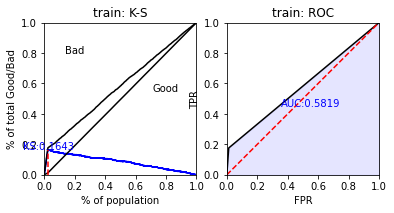

best:0.930543 useing {'C': 0.2653393377137663, 'penalty': 'l1', 'solver': 'liblinear'}


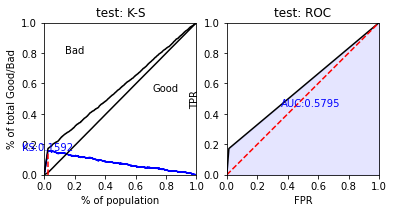

{'KS': 0.1592,
 'AUC': 0.5795,
 'Gini': 0.1591,
 'pic': <Figure size 432x288 with 2 Axes>}

In [188]:
sc.perf_eva(y_train,lr.BestModelPredict(x_train[coef_col]),title = "train" )
sc.perf_eva(y_test,lr.BestModelPredict(x_test[coef_col]),title = "test" )

In [438]:
#写死的训练模型
lr = LogisticRegression(penalty = 'l2',C=0.07,solver='liblinear')
#lr = LogisticRegression(penalty = 'l1',C=0.9,solver='saga')
lr.fit(x_train[coef_col],y_train)

LogisticRegression(C=0.07, solver='liblinear')

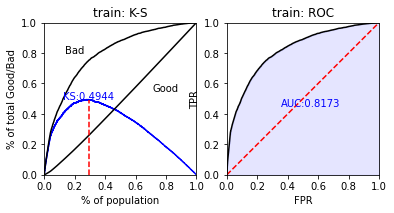

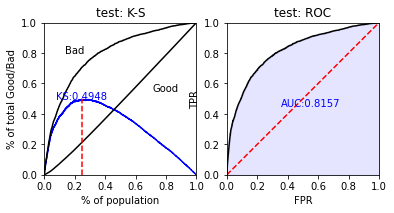

{'KS': 0.4948,
 'AUC': 0.8157,
 'Gini': 0.6315,
 'pic': <Figure size 432x288 with 2 Axes>}

In [439]:
sc.perf_eva(y_train,lr.predict_proba(x_train[coef_col])[:,1],title = "train" )
sc.perf_eva(y_test,lr.predict_proba(x_test[coef_col])[:,1],title = "test" )

# 评分卡

In [440]:
col = dft[coef_col].columns

In [442]:
card = sc.scorecard(bins,lr,col,points0=450,odds0 = 1/9,pdo = 50)
df_score = df_num[[x.split("_")[0] for x in coef_col]]

In [443]:
df_score.head()

,月收入,不安全线路的轮换,年龄,受抚养人数量,逾期90天次数,利率
0,9120.0,0.766127,45,2,0,0.802982
1,2600.0,0.957151,40,1,0,0.121876
2,3042.0,0.658180,38,0,1,0.085113
3,3300.0,0.233810,30,0,0,0.036050
4,63588.0,0.907239,49,0,0,0.024926


In [444]:
df_card = pd.DataFrame()
for i in card.keys():
    df_card = pd.concat((df_card,card[i]))


In [445]:
df_card.to_csv(r'D:\score_card\data\score_card.csv')

# 评分分布验证

In [446]:
scores = sc.scorecard_ply(df_score,card,print_step=0)

<AxesSubplot:xlabel='score', ylabel='Density'>

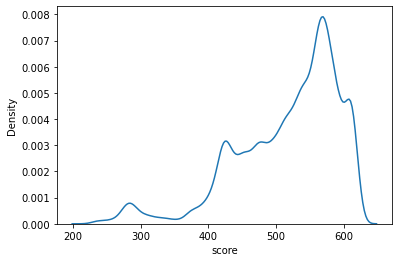

In [447]:
sns.kdeplot(scores['score'])

In [448]:
scores['label'] = dft['label']

In [449]:
"""
以上内容是风控评分卡建模全流程，最终输出了一张分箱评分的结果card

1.但是现在需要在这个结果基础上去新增特征重新建卡

2.通过BSI结果删除异常的特征，仅对剩余的特征进行打分，供生产应用



"""

'\n以上内容是风控评分卡建模全流程，最终输出了一张分箱评分的结果card\n\n1.但是现在需要在这个结果基础上去新增特征重新建卡\n\n2.通过BSI结果删除异常的特征，仅对剩余的特征进行打分，供生产应用\n\n\n\n'

In [450]:
df_card = pd.read_csv('D:\score_card\data\score_card.csv')
df_card

,Unnamed: 0,variable,bin,points
0,0,basepoints,NaN,477.0
1,0,月收入,"[-inf,3500.0)",-3.0
2,1,月收入,"[3500.0,5000.0)",-2.0
3,2,月收入,"[5000.0,6500.0)",0.0
4,3,月收入,"[6500.0,7500.0)",2.0
5,4,月收入,"[7500.0,10000.0)",3.0
6,5,月收入,"[10000.0,14000.0)",6.0
7,6,月收入,"[14000.0,inf)",4.0
8,7,不安全线路的轮换,"[-inf,0.1)",68.0
9,8,不安全线路的轮换,"[0.1,0.2)",46.0


In [451]:
df_card.drop(df_card[["Unnamed: 0"]],axis=1,inplace=True)
df_card

,variable,bin,points
0,basepoints,NaN,477.0
1,月收入,"[-inf,3500.0)",-3.0
2,月收入,"[3500.0,5000.0)",-2.0
3,月收入,"[5000.0,6500.0)",0.0
4,月收入,"[6500.0,7500.0)",2.0
5,月收入,"[7500.0,10000.0)",3.0
6,月收入,"[10000.0,14000.0)",6.0
7,月收入,"[14000.0,inf)",4.0
8,不安全线路的轮换,"[-inf,0.1)",68.0
9,不安全线路的轮换,"[0.1,0.2)",46.0


In [244]:
"""
#处理变量名对英文名对照字
f = open("var2list.txt","r",encoding = "utf8")

r = f.readlines()
dt = {}
for info in r:
    info = info.replace("\n","").split("\t")
    dt[info[1].strip().upper()] = info[0].strip().upper()
"""


,variable,bin,points
0,basepoints,NaN,477.0
1,age,"[-inf,30.0)",-17.0
2,age,"[30.0,36.0)",-14.0
3,age,"[36.0,44.0)",-9.0
4,age,"[44.0,54.0)",-4.0
5,age,"[54.0,58.0)",4.0
6,age,"[58.0,64.0)",12.0
7,age,"[64.0,68.0)",23.0
8,age,"[68.0,inf)",33.0
9,NumberOfTimes90DaysLate,"[-inf,1.0)",20.0


In [491]:
var_list = [x for x in set(df_card['variable']) if x !='basepoints']

In [310]:
# var_list = [dt[x.upper()] for x in var_list if x.upper() in dt.keys()]

In [452]:
"""
如果通过basepoints(bsi)发现需要删除某些特征
"""
sel = ['basepoints',
 '年龄',
 '逾期90天次数',
 '受抚养人数量',
 '月收入',
 '不安全线路的轮换',
 '利率']
df_card = df_card.set_index("variable").loc[sel].reset_index()

In [453]:
df_card.groupby("variable").max().points.sum()

626.0

In [454]:
df_card.groupby("variable").min().points.sum()

221.0

In [455]:
df_card

,variable,bin,points
0,basepoints,NaN,477.0
1,年龄,"[-inf,30.0)",-17.0
2,年龄,"[30.0,36.0)",-14.0
3,年龄,"[36.0,44.0)",-9.0
4,年龄,"[44.0,54.0)",-4.0
5,年龄,"[54.0,58.0)",3.0
6,年龄,"[58.0,64.0)",12.0
7,年龄,"[64.0,68.0)",23.0
8,年龄,"[68.0,inf)",33.0
9,逾期90天次数,"[-inf,1.0)",20.0


# 读取训练数据 并取相应特征的数据

In [ ]:
# 读取原数据
df_num = pd.read_csv(r"D:\score_card\data\cs-training.csv")

df_num.drop(df_num[["Unnamed: 0"]],axis=1,inplace=True)

df_num = df_num.rename(columns = {'SeriousDlqin2yrs':'label'})

#处理变量名对英文名对照字
f = open("var2list.txt","r",encoding = "utf8")

r = f.readlines()
dt = {}
for info in r:
    info = info.replace("\n","").split("\t")
    dt[info[1].strip().upper()] = info[0].strip().upper()

df_score = df_num[[x for x in df_num.columns if x.upper() in dt.keys()]+['label']]

df_score.columns = [dt[x.upper()] for x in df_num.columns if x.upper() in dt.keys()] + ['label'] 

df_score = df_score[var_list+['label']]

In [493]:
df_score.columns

Index(['不安全线路的轮换', '年龄', '逾期30-59天', '利率', '月收入', '未结信贷额度和贷款数量', '逾期90天次数',
       '房地产贷款或贷款行数', '逾期60-89天', '受抚养人数量', 'label'],
      dtype='object')

In [494]:
df_score = df_score[sel[1:]+['label']]

In [495]:
df_score.head()

,年龄,逾期90天次数,受抚养人数量,月收入,不安全线路的轮换,利率,label
0,45,0,2.0,9120.0,0.766127,0.802982,1
1,40,0,1.0,2600.0,0.957151,0.121876,0
2,38,1,0.0,3042.0,0.658180,0.085113,0
3,30,0,0.0,3300.0,0.233810,0.036050,0
4,49,0,0.0,63588.0,0.907239,0.024926,0


# 将训练数据作评分映射

In [496]:
scores = sc.scorecard_ply(df_score,df_card,print_step=0)

In [497]:
df_score['score'] = scores

<AxesSubplot:xlabel='score', ylabel='Density'>

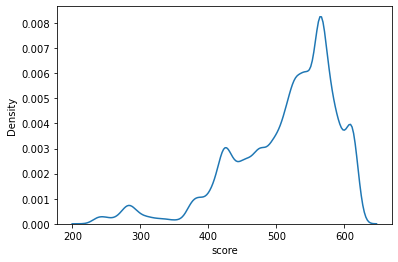

In [501]:
sns.kdeplot(df_score['score'],label = "0")

<AxesSubplot:xlabel='score', ylabel='Density'>

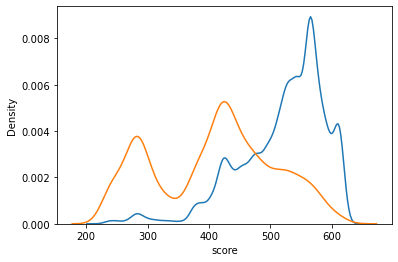

In [508]:
sns.kdeplot(df_score.loc[df_score.label == 0]['score'],label = "0")
sns.kdeplot(df_score.loc[df_score.label == 1]['score'],label = "1")

# 寻找切分点

In [526]:
df_cnt = df_score[['label','score']]

In [527]:
df_cnt['score'] = df_cnt['score'].apply(lambda x :x if (x>=0)&(x<=1000) else (0 if x <0 else 1000))

In [532]:
df_cnt['score_adj'] = (df_cnt.score)/1000*0.6*100+40


,label,score,score_adj
0,1,412.0,64.72
1,0,417.0,65.02
2,0,343.0,60.58
3,0,530.0,71.80
4,0,441.0,66.46
...,...,...,...
149995,0,617.0,77.02
149996,0,486.0,69.16
149997,0,511.0,70.66
149998,0,567.0,74.02


In [533]:
result = []
for i in np.linspace(40,100,60):
    cnt = int(i)
    tp = df_cnt.loc[df_cnt.score_adj <=cnt]
    cnt_good = len(tp.loc[tp.label == 0])
    cnt_bad = len(tp.loc[tp.label == 1])
    context = [cnt,cnt_good,cnt_bad]
    result.append(context)
result = pd.DataFrame(result)
result.columns = ['切分点','覆盖坏样本数','覆盖好样本数']

In [534]:
result['召回率'] = result['覆盖坏样本数']/len(df_cnt.loc[df_cnt.label ==0])
result['真阳率'] = result['覆盖坏样本数']/(result['覆盖坏样本数']+result['覆盖好样本数'])

In [536]:
result

,切分点,覆盖坏样本数,覆盖好样本数,召回率,真阳率
0,40,0,0,0.000000,NaN
1,41,0,0,0.000000,NaN
2,42,0,0,0.000000,NaN
3,43,0,0,0.000000,NaN
4,44,0,0,0.000000,NaN
5,45,0,0,0.000000,NaN
6,46,0,0,0.000000,NaN
7,47,0,0,0.000000,NaN
8,48,0,0,0.000000,NaN
9,49,0,0,0.000000,NaN


In [535]:
result.loc[result['召回率']>0.3]

,切分点,覆盖坏样本数,覆盖好样本数,召回率,真阳率
30,70,43866,8071,0.313387,0.844600
31,71,53444,8436,0.381814,0.863672
32,72,67561,8862,0.482668,0.884040
33,73,82479,9209,0.589245,0.899562
34,74,102100,9541,0.729421,0.914539
35,75,117640,9808,0.840442,0.923043
36,76,127478,9934,0.910726,0.927706
37,77,137704,10015,0.983783,0.932202
38,78,139974,10026,1.000000,0.933160
39,79,139974,10026,1.000000,0.933160
